## Topic Modelling

<b> Author:</b> Miraya Gupta \
<b> Date: </b> 04/05

## Table of Contents
1. [Loading Data](#ld)
2. [Preprocessing Data](#pd)
3. [Creating Vectors](#cm)
4. [Fitting Model](#fm)
5. [Grid Search](#gs)
#6. [Popularity Analysis by User over Time](#by-user-over-time)

In [172]:
#importing packages
import pandas as pd
import csv
import json
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis

In [38]:
pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 1. Loading Data<a id="ld"></a>

In [2]:
def get_df_for_year(year):
    '''
    Take in the year and return a df with data from that year
    '''
    directory = 'data'
    filename = f'final_result_{year}.csv'
    path = os.path.join(directory, filename)
    df = pd.read_csv(path)
    return df

In [3]:
#calling function to get csv for each year
all_dfs = []
for yr in ['2020', '2021', '2022', '2023', '2024']:
    df = get_df_for_year(yr)
    all_dfs.append(df)

In [4]:
#testing
all_dfs[0].columns

Index(['Unnamed: 0', 'video_id', 'video_timestamp', 'video_duration',
       'video_locationcreated', 'suggested_words', 'video_diggcount',
       'video_sharecount', 'video_commentcount', 'video_playcount',
       'video_description', 'video_is_ad', 'video_stickers', 'author_username',
       'author_name', 'author_followercount', 'author_followingcount',
       'author_heartcount', 'author_videocount', 'author_diggcount',
       'author_verified', 'search_term', 'year', 'File Name', 'Content',
       'Subjectivity/Objectivity'],
      dtype='object')

<b> The column 'content' contains the document information for each video. </b>

## 2. Preprocessing Data<a id="pd"></a>

In [5]:
#concatenate all
allDocs = pd.concat(all_dfs)

In [6]:
#testing
allDocs.shape

(17062, 31)

In [7]:
pd.set_option("display.max_colwidth",1000)

In [43]:
#make video ID the index 
allDocs.set_index('video_id', inplace=True)

In [44]:
allDocs.head(2)

,Unnamed: 0,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,year,File Name,Content,Subjectivity/Objectivity,transcript_File Name,transcript_Content,transcript_Unnamed: 0,transcript_Subjectivity/Objectivity,transcript_video_id,terms
video_id,,,,,,,,,,,,,,,,,,,,,
7104707494194269482,0.0,2022-06-02T14:13:40,15.0,US,NaN,106.0,1.0,4.0,4690.0,We do a lot 😂👍🏻 #foryou #publicsafety,...,2020.0,@chayse.me_video_7104707494194269482.txt,electronica esosledge och,not sure,NaN,NaN,NaN,NaN,NaN,"[electronica, esosledge, och]"
7167954365922151726,1.0,2022-11-19T23:43:58,23.0,US,NaN,35800.0,974.0,228.0,323000.0,No public safety schedule is glamorous…!! #copsoftiktok #firefighter #publicsafety #threebestfriends #ems #tiktok #fyp,...,2020.0,@elevendouble9_video_7167954365922151726.txt,"What's your schedule like coming here? We work on 6 a.m. every day. 6 a.m. We're going to get here. We're going to get here at 5.30 to stretch and warm up. What the hell time do you get up? About like 4.45. What time do you get up? 9.30. Guess there's no lonely nights if you're going to bed at 9. Yeah, go to bed early. Where are you? Oh, wait a second. I'm not just thinking about life. What is there to think about it that time?",subjective,NaN,NaN,NaN,NaN,NaN,"[bed, coming, day, early, going, guess, hell, just, life, like, lonely, nights, schedule, second, stretch, think, thinking, time, wait, warm, work, yeah]"


In [45]:
nan_indices = allDocs['Content'].isnull()
allDocs = allDocs.dropna(subset=['Content'])

In [46]:
# Initialize the vectorizer
vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b', # we want only words that contain letters and are 3 or more characters long
)

# Transform our data into the document-term matrix
dtm = vectorizer.fit_transform(allDocs['Content'])
dtm

<11167x25340 sparse matrix of type '<class 'numpy.int64'>'
	with 644396 stored elements in Compressed Sparse Row format>

## 3. Creating Vectors <a id="cm"></a>

In [47]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['aaaaaahhh', 'aachenklaas', 'aachenklaus', ..., 'zygote', 'zypact',
       'zyprophloxicin'], dtype=object)

In [48]:
feature_names.shape

(25340,)

In [49]:
feature_names[300:350]

array(['adjacent', 'adjouish', 'adjourned', 'adju', 'adjudicate',
       'adjudicated', 'adjudication', 'adjust', 'adjusted', 'adjuster',
       'adjustment', 'adl', 'admin', 'administer', 'administered',
       'administers', 'administracion', 'administration',
       'administrations', 'administrative', 'administrator', 'admiral',
       'admiration', 'admire', 'admired', 'admissibility', 'admission',
       'admissions', 'admit', 'admits', 'admitted', 'admittedly',
       'admitting', 'admusy', 'ado', 'adoe', 'adolescent', 'adolescents',
       'adolf', 'adopt', 'adopted', 'adopting', 'adoption', 'adoration',
       'adorned', 'adou', 'adquienes', 'adreisi', 'adrenal', 'ads'],
      dtype=object)

<b>Observation: there are several words here with the same root word such as 'administered', 'administration' and words with the same root word in other languages such as 'administracion'</b>

In [50]:
doc1 = dtm[0]
doc1

<1x25340 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [51]:
row_index = 0
doc_vec = dtm.getrow(row_index).toarray()

non_zero_indices = doc_vec.nonzero()[1]
dtm_scores = doc_vec[0, non_zero_indices] # goes and retrieves the values corresponding to the non_zero_indices
words = [feature_names[i] for i in non_zero_indices]

for word, score in zip(words, dtm_scores):
    print(f"{word}: {score}")

electronica: 1
esosledge: 1
och: 1


In [52]:
non_zero_indices

array([ 7181,  7664, 15590])

In [53]:
dtm.getcol(7181).toarray().T.sum()

5

In [54]:
np.count_nonzero(dtm.getcol(7664).toarray().T)

5

In [55]:
dct = {}
for i in range(15590):
    value = np.count_nonzero(dtm.getcol(i).toarray().T)
    key =  feature_names[i]
    dct[key] = value
sorted(dct.items(), reverse = True, key=lambda index : index[1])[:5]

[('just', 4177),
 ('like', 4086),
 ('know', 3699),
 ('don', 3255),
 ('going', 2928)]

<b> Hard to tell if these words are part of a topic, since they are very general. What does come across is that most of the words are conversational, such as actually or called. </b>

In [56]:
def matrix2Doc(dtMatrix, features, index):
    """Turns each row of the document-term matrix into a list of terms"""
    row = dtMatrix.getrow(index).toarray()
    non_zero_indices = row.nonzero()[1]
    words = [features[idx] for idx in non_zero_indices]
    return words

In [57]:
allDocsAsTerms = [matrix2Doc(dtm, feature_names, i) for i in range(dtm.shape[0])]

In [59]:
allDocs['terms'] = allDocsAsTerms
allDocs.head()

,Unnamed: 0,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,year,File Name,Content,Subjectivity/Objectivity,transcript_File Name,transcript_Content,transcript_Unnamed: 0,transcript_Subjectivity/Objectivity,transcript_video_id,terms
video_id,,,,,,,,,,,,,,,,,,,,,
7104707494194269482,0.0,2022-06-02T14:13:40,15.0,US,NaN,106.0,1.0,4.0,4690.0,We do a lot 😂👍🏻 #foryou #publicsafety,...,2020.0,@chayse.me_video_7104707494194269482.txt,electronica esosledge och,not sure,NaN,NaN,NaN,NaN,NaN,"[electronica, esosledge, och]"
7167954365922151726,1.0,2022-11-19T23:43:58,23.0,US,NaN,35800.0,974.0,228.0,323000.0,No public safety schedule is glamorous…!! #copsoftiktok #firefighter #publicsafety #threebestfriends #ems #tiktok #fyp,...,2020.0,@elevendouble9_video_7167954365922151726.txt,"What's your schedule like coming here? We work on 6 a.m. every day. 6 a.m. We're going to get here. We're going to get here at 5.30 to stretch and warm up. What the hell time do you get up? About like 4.45. What time do you get up? 9.30. Guess there's no lonely nights if you're going to bed at 9. Yeah, go to bed early. Where are you? Oh, wait a second. I'm not just thinking about life. What is there to think about it that time?",subjective,NaN,NaN,NaN,NaN,NaN,"[bed, coming, day, early, going, guess, hell, just, life, like, lonely, nights, schedule, second, stretch, think, thinking, time, wait, warm, work, yeah]"
7277689387939417386,2.0,2023-09-11T17:52:00,46.0,US,NaN,157600.0,2252.0,163.0,839100.0,That must mean the car is in the bike #collegelife #campussecurity #publicsafety #stolenbikes #college,...,2020.0,@collegelifeshorts_video_7277689387939417386.txt,"Hey, I got my bike stolen. Oh nice. Okay. Great. Yes. Do we have a list of suspects? Yeah, no I think it was just someone random. I left it unlocked. Do you have any close friends? Do you have any friends? Yes? It was him. Let's ride Something's not adding up. Okay. I have a couple leads. I'm hoping the university is willing to fund. I found it You know supposed to have that candle also my car got broken in Maybe that's where your bike went. I found my bike. So your car is stolen We'll have to lure the culprit back onto campus before I can do anything about it. Is that a vapor? Yeah, you can't have that. Yeah, I can I'm just gonna call the actual no, no, no, no, no once we get him back I'll revoke their parking pass can't guarantee we'll get the car back But I will get the pass bottom line you will no longer have a parking pass. Oh, there's your bike That must mean your car is somewhere in this room",subjective,NaN,NaN,NaN,NaN,NaN,"[actual, adding, bike, broken, campus, candle, car, close, couple, culprit, friends, fund, gonna, got, great, guarantee, hey, hoping, just, know, leads, left, let, line, list, longer, lure, maybe, mean, nice, okay, parking, pass, random, revoke, ride, room, stolen, supposed, suspects, think, university, unlocked, vapor, went, willing, yeah, yes]"
7176634327122365738,3.0,2022-12-13T09:06:40,20.0,US,"disposable straws, disposable pot",1100000.0,249900.0,13800.0,15800000.0,"@tiktok this ISN’T a promotion, its a PSA. (But lets use a backup in case) This platform has too many users whom present them as being safe 🤦‍♂️ #vape #vapor #ecig #elfbar #elfbars #disposable #vapetok #psa #publichealth #pulmonary #lungs #notsafe #quitter #quit #quitsmoking #quitvaping",...,2020.0,@adequatevapor_video_7176634327122365738.txt,"I am reposting this here because I just assumed that I have some followers on all platforms that happen to use these things. This is an Elf Bar, a legitimate Elf Bar, not that that really matters. If it tastes like it's almost out of juice, get a new one. Don't keep using it because you're going to end up inhaling plastic,",subjective,NaN,NaN,NaN,NaN,NaN,"[assumed, bar, don, elf, end, followers, going, happen, inhaling, juice, just, legitimate, like, matters, new, plas

<b> Limitations of the terms in capturing the meaning of the transcripts </b>
1. Proper nouns like 'Elf' from 'Elf Bars' and 'Adolf' from 'Adolf Hitler' are interpreted as common nouns.
2. Some words are incomprehensible in English, for example 'och'. This could be a limitation of the transcription rather than the term extraction.
3. Some words that should technically be stopwords within the given context of the transcript are left in.
4. Some platform specific words like 'reposting' are captured as words that add meaning to the transcript. 

## 4. Fitting Model <a id="fm"></a>

In [61]:
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Initialize the model

lda = LatentDirichletAllocation(n_components=300, # we are picking the number of topics arbitrarely at the moment
                                random_state=0)

# Step 2: Fit the model
lda.fit(dtm)

LatentDirichletAllocation(n_components=300, random_state=0)

In [62]:
#accessing representations of topics
lda.components_

array([[0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333],
       [0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333],
       [0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333],
       ...,
       [0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333],
       [0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333],
       [0.00333333, 0.00333333, 0.00333333, ..., 0.00333333, 0.00333333,
        0.00333333]])

In [63]:
lda.components_.shape

(300, 25340)

Each row is one of 15 topics and each column is a specific term. The numbers represent how many times a specific term was assigned to a topic in the corpus. 

In [64]:
def display_topics(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([features[i]
                        for i in topic.argsort()[:-no_top_words-1:-1]])) # syntax for reversing a list [::-1]

display_topics(lda, feature_names, 15)

Topic 0:
god land jews christ abraham say israel son jesus people promise man father aye promised
Topic 1:
thank president days god like time montez america yeah great day break hundreds art united
Topic 2:
like really stimulus make patient email claim victims sure didn know stroke families let checks
Topic 3:
sit bush hair trump jewish donald look child legal giuliani balfour declaration advice looks cut
Topic 4:
peace israel going like jesus war just world time come years lot israeli white knows
Topic 5:
speech israel rights school going muslims security homeland department palestinian freedom fbi family case belknapp
Topic 6:
voter pennsylvania registration states people aviv tel live course license vote voters state got stuff
Topic 7:
policy like people come end zionism lot jewish biden just shout government public things different
Topic 8:
know base minnesota don people home highest dfl candidates research election peace breast cancer success
Topic 9:
palestinians lauder jewish do

In [184]:
def save_topics(model, features, no_top_words):
    dct = {}
    for topic_idx, topic in enumerate(model.components_):
        dct[topic_idx] = (" ".join([features[i]
                        for i in topic.argsort()[:-no_top_words-1:-1]]))
        #print # syntax for reversing a list [::-1]
    return dct
topics = save_topics(lda, feature_names, 15)
topics_df = pd.DataFrame(list(topics.items()), columns=['Top Num', 'topic_words'])

In [185]:
topics_df

,Top Num,topic_words
0,0,god land jews christ abraham say israel son jesus people promise man father aye promised
1,1,thank president days god like time montez america yeah great day break hundreds art united
2,2,like really stimulus make patient email claim victims sure didn know stroke families let checks
3,3,sit bush hair trump jewish donald look child legal giuliani balfour declaration advice looks cut
4,4,peace israel going like jesus war just world time come years lot israeli white knows
...,...,...
295,295,president whistleblower biden anonymous republicans ini kena dia depan second passport whistleblowers know tak country
296,296,senator public community program data know turnout really voter grants need safety office transparency heard
297,297,money lot let don need people want time tough just know reason donors say going
298,298,eso padre que people borderline personality disorder ella esto doctora porque going abandonment guard por


Two topics pertain very clearly to the conflict in Gaza, 0, 4 and 13. Topic 0 seems to connect more with the religious element of the conflict, 4 with the funding and 13 with the armed conflict. 

In [65]:
doc_topic_dist = lda.transform(dtm)
doc_topic_dist

array([[1.66666667e-03, 1.66666667e-03, 1.66666667e-03, ...,
        1.66666667e-03, 1.66666667e-03, 1.66666667e-03],
       [1.14942529e-04, 1.14942529e-04, 1.14942529e-04, ...,
        1.14942529e-04, 1.14942529e-04, 1.14942529e-04],
       [5.05050505e-05, 5.05050505e-05, 5.05050505e-05, ...,
        5.05050505e-05, 5.05050505e-05, 5.05050505e-05],
       ...,
       [4.76190476e-05, 4.76190476e-05, 4.76190476e-05, ...,
        4.76343333e-05, 4.76190476e-05, 4.76190476e-05],
       [4.11522634e-05, 4.11522634e-05, 4.11522634e-05, ...,
        4.11522634e-05, 4.11522634e-05, 4.11522634e-05],
       [1.11111111e-03, 1.11111111e-03, 1.11111111e-03, ...,
        1.11111111e-03, 1.11111111e-03, 1.11111111e-03]])

In [66]:
doc_topic_dist.shape

(11167, 300)

In [67]:
def displayHeader(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    topicNames = []
    for topic_idx, topic in enumerate(model.components_):
        topicNames.append(f"Topic {topic_idx}: " + (", ".join([features[i]
                             for i in topic.argsort()[:-no_top_words-1:-1]])))
    return topicNames

In [68]:
# column names
topicnames = displayHeader(lda, feature_names, 5)

# index names
docnames = allDocs.index.tolist() # We will use the original names of the documents

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 3), 
                                 columns=topicnames, 
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1) # finds the maximum argument
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,"Topic 0: god, land, jews, christ, abraham","Topic 1: thank, president, days, god, like","Topic 2: like, really, stimulus, make, patient","Topic 3: sit, bush, hair, trump, jewish","Topic 4: peace, israel, going, like, jesus","Topic 5: speech, israel, rights, school, going","Topic 6: voter, pennsylvania, registration, states, people","Topic 7: policy, like, people, come, end","Topic 8: know, base, minnesota, don, people","Topic 9: palestinians, lauder, jewish, don, israel",...,"Topic 291: like, just, know, information, want","Topic 292: love, tell, okay, don, like","Topic 293: day, republican, war, kansas, night","Topic 294: don, number, asked, senator, numbers","Topic 295: president, whistleblower, biden, anonymous, republicans","Topic 296: senator, public, community, program, data","Topic 297: money, lot, let, don, need","Topic 298: eso, padre, que, people, borderline","Topic 299: elected, government, officials, age, party",dominant_topic
7104707494194269482,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,198
7167954365922151726,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,39
7277689387939417386,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,96
7176634327122365738,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,82
7212690611852578094,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,253


In [69]:
df_document_topic.shape

(11167, 301)

In [72]:
df_document_topic.to_csv('document_topic.csv')

In [70]:
df_document_topic[76:86]

,"Topic 0: god, land, jews, christ, abraham","Topic 1: thank, president, days, god, like","Topic 2: like, really, stimulus, make, patient","Topic 3: sit, bush, hair, trump, jewish","Topic 4: peace, israel, going, like, jesus","Topic 5: speech, israel, rights, school, going","Topic 6: voter, pennsylvania, registration, states, people","Topic 7: policy, like, people, come, end","Topic 8: know, base, minnesota, don, people","Topic 9: palestinians, lauder, jewish, don, israel",...,"Topic 291: like, just, know, information, want","Topic 292: love, tell, okay, don, like","Topic 293: day, republican, war, kansas, night","Topic 294: don, number, asked, senator, numbers","Topic 295: president, whistleblower, biden, anonymous, republicans","Topic 296: senator, public, community, program, data","Topic 297: money, lot, let, don, need","Topic 298: eso, padre, que, people, borderline","Topic 299: elected, government, officials, age, party",dominant_topic
7237695111696534826,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,91
7141756052248513838,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,29
6821225299611618565,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,90
7057660231681281326,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,228
6891362397265595653,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,262
6936273435064536326,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,144
7327792589103500586,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,26
6948580219380878598,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,186
6877653527330639110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,154
6959318121584807174,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,147


In [71]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,681
1,292,83
2,268,76
3,16,75
4,232,73
...,...,...
295,187,14
296,275,13
297,165,13
298,227,12


## 5. Grid Search <a id="gs"></a>

In [35]:
from sklearn.model_selection import GridSearchCV

# We are going to test multiple values for the number of topics
search_params = {'n_components': [5, 10, 15, 20, 25, 30, 35]}

# Initialize the LDA model
lda = LatentDirichletAllocation()

# Initialize a Grid Search with cross-validation instance
grid = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
grid.fit(dtm)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35]})

In [36]:
# Best Model
best_lda_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -1788081.916466641
Model Perplexity:  3292.1432432654024


In [37]:
search_params = {'n_components': [1,2,3,4,5,6]}

lda = LatentDirichletAllocation()
grid = GridSearchCV(lda, param_grid=search_params)

grid.fit(dtm)

# Best Model
best_lda_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

Best Model's Params:  {'n_components': 1}
Best Log Likelihood Score:  -1690852.9608383111
Model Perplexity:  4115.418016987782


In [39]:
display_topics(best_lda_model, feature_names, 40)

Topic 0:
like people just know going don right want think israel time say really let trump make state president need got states said vote way lot day did things new look years actually world country come year money okay government palestinian


## Fitting a Model with 300 topics, one for each search term

In [76]:
df_doc_top = pd.read_csv('document_topic.csv')

In [79]:
df_doc_top.head()

,Unnamed: 0,"Topic 0: god, land, jews, christ, abraham","Topic 1: thank, president, days, god, like","Topic 2: like, really, stimulus, make, patient","Topic 3: sit, bush, hair, trump, jewish","Topic 4: peace, israel, going, like, jesus","Topic 5: speech, israel, rights, school, going","Topic 6: voter, pennsylvania, registration, states, people","Topic 7: policy, like, people, come, end","Topic 8: know, base, minnesota, don, people",...,"Topic 291: like, just, know, information, want","Topic 292: love, tell, okay, don, like","Topic 293: day, republican, war, kansas, night","Topic 294: don, number, asked, senator, numbers","Topic 295: president, whistleblower, biden, anonymous, republicans","Topic 296: senator, public, community, program, data","Topic 297: money, lot, let, don, need","Topic 298: eso, padre, que, people, borderline","Topic 299: elected, government, officials, age, party",dominant_topic
0,7104707494194269482,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,198
1,7167954365922151726,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,39
2,7277689387939417386,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,96
3,7176634327122365738,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,82
4,7212690611852578094,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,253


In [80]:
df_doc_top['Unnamed: 0']

0        7104707494194269482
1        7167954365922151726
2        7277689387939417386
3        7176634327122365738
4        7212690611852578094
                ...         
11162    7239030289022979371
11163    7327480752940059950
11164    7293650230640168238
11165    7293103212528241966
11166    7358119678851468586
Name: Unnamed: 0, Length: 11167, dtype: int64

In [85]:
df_doc_top.rename(columns={'Unnamed: 0': 'video_id'}, inplace=True)

In [86]:
merged_df = pd.merge(allDocs, df_doc_top, on='video_id') 

In [87]:
merged_df.columns

Index(['video_id', 'Unnamed: 0', 'video_timestamp', 'video_duration',
       'video_locationcreated', 'suggested_words', 'video_diggcount',
       'video_sharecount', 'video_commentcount', 'video_playcount',
       ...
       'Topic 291: like, just, know, information, want',
       'Topic 292: love, tell, okay, don, like',
       'Topic 293: day, republican, war, kansas, night',
       'Topic 294: don, number, asked, senator, numbers',
       'Topic 295: president, whistleblower, biden, anonymous, republicans',
       'Topic 296: senator, public, community, program, data',
       'Topic 297: money, lot, let, don, need',
       'Topic 298: eso, padre, que, people, borderline',
       'Topic 299: elected, government, officials, age, party',
       'dominant_topic'],
      dtype='object', length=333)

In [89]:
merged_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [90]:
merged_df.columns

Index(['video_id', 'video_timestamp', 'video_duration',
       'video_locationcreated', 'suggested_words', 'video_diggcount',
       'video_sharecount', 'video_commentcount', 'video_playcount',
       'video_description',
       ...
       'Topic 291: like, just, know, information, want',
       'Topic 292: love, tell, okay, don, like',
       'Topic 293: day, republican, war, kansas, night',
       'Topic 294: don, number, asked, senator, numbers',
       'Topic 295: president, whistleblower, biden, anonymous, republicans',
       'Topic 296: senator, public, community, program, data',
       'Topic 297: money, lot, let, don, need',
       'Topic 298: eso, padre, que, people, borderline',
       'Topic 299: elected, government, officials, age, party',
       'dominant_topic'],
      dtype='object', length=332)

In [110]:
#drop duplicate video ids
merged_df.drop_duplicates(subset=['video_id'], inplace = True)

In [111]:
grouped_df = merged_df.groupby('search_term')

In [112]:
grouped_df.head()

,video_id,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,"Topic 291: like, just, know, information, want","Topic 292: love, tell, okay, don, like","Topic 293: day, republican, war, kansas, night","Topic 294: don, number, asked, senator, numbers","Topic 295: president, whistleblower, biden, anonymous, republicans","Topic 296: senator, public, community, program, data","Topic 297: money, lot, let, don, need","Topic 298: eso, padre, que, people, borderline","Topic 299: elected, government, officials, age, party",dominant_topic
0,7104707494194269482,2022-06-02T14:13:40,15.0,US,NaN,106.0,1.0,4.0,4690.0,We do a lot 😂👍🏻 #foryou #publicsafety,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,198
5,7167954365922151726,2022-11-19T23:43:58,23.0,US,NaN,35800.0,974.0,228.0,323000.0,No public safety schedule is glamorous…!! #copsoftiktok #firefighter #publicsafety #threebestfriends #ems #tiktok #fyp,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,39
10,7277689387939417386,2023-09-11T17:52:00,46.0,US,NaN,157600.0,2252.0,163.0,839100.0,That must mean the car is in the bike #collegelife #campussecurity #publicsafety #stolenbikes #college,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,96
14,7176634327122365738,2022-12-13T09:06:40,20.0,US,"disposable straws, disposable pot",1100000.0,249900.0,13800.0,15800000.0,"@tiktok this ISN’T a promotion, its a PSA. (But lets use a backup in case) This platform has too many users whom present them as being safe 🤦‍♂️ #vape #vapor #ecig #elfbar #elfbars #disposable #vapetok #psa #publichealth #pulmonary #lungs #notsafe #quitter #quit #quitsmoking #quitvaping",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,82
18,7212690611852578094,2023-03-20T14:03:32,50.0,US,NaN,15700.0,2171.0,1110.0,299900.0,It’s not about “safety” and it never has been. #chicago #crime #publicsafety #traffic,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,7208991189222149418,2023-03-10T13:47:48,26.0,US,NaN,114.0,6.0,14.0,2276.0,Bernie Sanders on: Super PACs in America. (Clip is from 2023 Interview with PoliticsJoe) -Follow my page for more political content Clips. #berniesanders #superpac #Politics #politik #politicaltiktok #marxism #Socialism #America #capitalism #Hasanpiker #hasanabi #political #PoliticsJOE #politicalactioncommittee,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202
52859,7260254830017383723,2023-07-26T18:16:52,134.0,US,NaN,24.0,1.0,1.0,2252.0,"Replying to @missypenny Political action committees are corrupt, m'kay? #fyp #superpacs #politics #uspolitics #eattherich",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,233
52863,7308492115187617055,2023-12-03T17:02:17,353.0,US,NaN,2413.0,890.0,342.0,36000.0,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,217
52867,7249082312736984366,2023-06-26T15:41:55,34.0,US,NaN,20700.0,1142.0,1395.0,198700.0,Trump has been caught again! #stophate #veteran #fyp #voteblue #tiktokdemocrats #gop #peopleoverprofits #trump #transparency #justice #trump2024 #trumpindictment,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3


1120 rows represent videos. columns represent features of each video. 

In [113]:
# calculate what proportion of the search results for a given search term have corresponded to the same topic. 

In [114]:
no_of_groups = 0
for group_name, group_data in grouped_df:
    print("Group:", group_name)
    no_of_groups += 1
print(f'total no of groups = {no_of_groups}')

Group: Al Shifa Hospital (Gaza Strip)
Group: Al-Aqsa Mosque
Group: American Civil Liberties Union
Group: Antifa Movement (US)
Group: Arab League
Group: Arab-Israeli War (1973)
Group: Balfour Declaration
Group: Ballots
Group: Bannon, Stephen K
Group: Biden, Joseph R Jr
Group: Biomedical Advanced Research and Development Authority
Group: Boycott, Divestment and Sanctions (BDS)
Group: Bozell, Leo Brent IV
Group: Camp David Accords
Group: Campaign Finance
Group: Campaign Strategy
Group: Capitol Building (Washington, DC)
Group: Caucuses
Group: Chansley, Jacob Anthony (Jake Angeli)
Group: Charlottesville, Va, Violence (August, 2017)
Group: Child Care
Group: Clinical Trials
Group: Community Support
Group: Confederate Flags
Group: Confederate States of America
Group: Congressional Progressive Caucus
Group: Conservatism (US Politics)
Group: Conservative Political Action Conference
Group: Consumer Protection
Group: Coronavirus (2019-nCoV)
Group: Cruz, Ted
Group: Debates (Political)
Group: Democr

In [115]:
search_term_topic_dct = {}
for group_name, group_data in grouped_df:
    print("Group:", group_name)
    dct = {'search_term' : group_name}
    dct[something] = something
    
    df = group_data
    search_term_topic_dct['statistics'] = group_name

    search_term_topic_dct['search_term'] = dct

Group: Al Shifa Hospital (Gaza Strip)


NameError: name 'something' is not defined

In [138]:
search_term_topic_dct = {}
for group_name, group_data in grouped_df:
    print("Group:", group_name)
    df = group_data
    #dct = {'search_term' : group_name}
    dct = {}
    #all videos
    no_of_videos = df.shape[0]
    dct['total_videos'] = no_of_videos

    #unique topics
    all_topics = df['dominant_topic'].value_counts()
    #print(f'all topics are {len(all_topics)}')
    #print(all_topics)
    dct['dom_topic'] = all_topics.idxmax()

    dct['dom_topic_ratio'] = max(all_topics)/no_of_videos

    search_term_topic_dct[group_name] = dct 
   # dct[something] = something
    

Group: Al Shifa Hospital (Gaza Strip)
Group: Al-Aqsa Mosque
Group: American Civil Liberties Union
Group: Antifa Movement (US)
Group: Arab League
Group: Arab-Israeli War (1973)
Group: Balfour Declaration
Group: Ballots
Group: Bannon, Stephen K
Group: Biden, Joseph R Jr
Group: Biomedical Advanced Research and Development Authority
Group: Boycott, Divestment and Sanctions (BDS)
Group: Bozell, Leo Brent IV
Group: Camp David Accords
Group: Campaign Finance
Group: Campaign Strategy
Group: Capitol Building (Washington, DC)
Group: Caucuses
Group: Chansley, Jacob Anthony (Jake Angeli)
Group: Charlottesville, Va, Violence (August, 2017)
Group: Child Care
Group: Clinical Trials
Group: Community Support
Group: Confederate Flags
Group: Confederate States of America
Group: Congressional Progressive Caucus
Group: Conservatism (US Politics)
Group: Conservative Political Action Conference
Group: Consumer Protection
Group: Coronavirus (2019-nCoV)
Group: Cruz, Ted
Group: Debates (Political)
Group: Democr

In [139]:
search_term_topic_dct

{'Al Shifa Hospital (Gaza Strip)': {'total_videos': 12,
  'dom_topic': 0,
  'dom_topic_ratio': 0.5},
 'Al-Aqsa Mosque': {'total_videos': 23,
  'dom_topic': 0,
  'dom_topic_ratio': 0.13043478260869565},
 'American Civil Liberties Union': {'total_videos': 22,
  'dom_topic': 174,
  'dom_topic_ratio': 0.09090909090909091},
 'Antifa Movement (US)': {'total_videos': 20,
  'dom_topic': 155,
  'dom_topic_ratio': 0.1},
 'Arab League': {'total_videos': 20, 'dom_topic': 0, 'dom_topic_ratio': 0.25},
 'Arab-Israeli War (1973)': {'total_videos': 9,
  'dom_topic': 0,
  'dom_topic_ratio': 0.4444444444444444},
 'Balfour Declaration': {'total_videos': 23,
  'dom_topic': 222,
  'dom_topic_ratio': 0.21739130434782608},
 'Ballots': {'total_videos': 15,
  'dom_topic': 108,
  'dom_topic_ratio': 0.13333333333333333},
 'Bannon, Stephen K': {'total_videos': 22,
  'dom_topic': 299,
  'dom_topic_ratio': 0.09090909090909091},
 'Biden, Joseph R Jr': {'total_videos': 11,
  'dom_topic': 159,
  'dom_topic_ratio': 0.18

## Plotting Results

In [144]:
#create df 
dct = {}
for search_term in search_term_topic_dct:
    dct[search_term] = search_term_topic_dct[search_term]['dom_topic_ratio']

In [187]:
df = pd.DataFrame(list(dct.items()), columns=['search_term', 'dom_topic_ratio'])
df.sort_values(by='dom_topic_ratio', ascending=False, inplace=True)

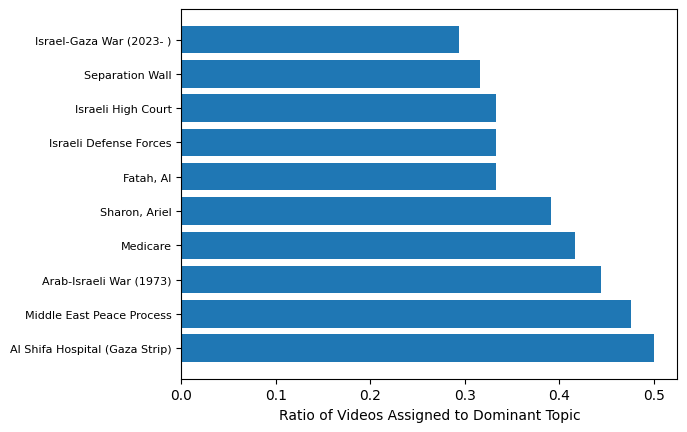

In [170]:
plt.barh(df['search_term'][:10], df['dom_topic_ratio'][:10])
#plt.xticks(rotation=9)
plt.xlabel('Ratio of Videos Assigned to Dominant Topic')
plt.tick_params(axis='y', which='major', labelsize=8)
plt.savefig('videos_assigned_to_dominant_topic_top10.png', bbox_inches='tight')

In [1]:
plt.barh(df['search_term'][214:224], df['dom_topic_ratio'][214:224])
plt.xlabel('Percent of Search Results Assigned to Same Topic')
plt.tick_params(axis='y', which='major', labelsize=8)
plt.savefig('videos_assigned_to_dominant_topic_bottom10.png', bbox_inches='tight')

NameError: name 'plt' is not defined

In [188]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Top Num', 'Num Documents']
df_use = pd.merge(df_topic_distribution, topics_df, on='Top Num', how='inner')

In [190]:
df_use.head()
df_use.sort_values(by='Num Documents', ascending = False, inplace=True)

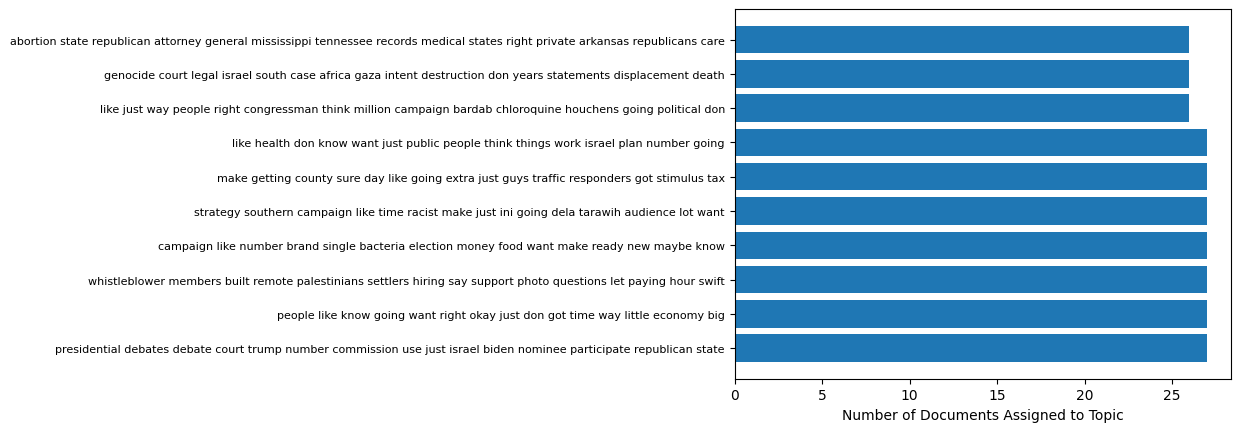

In [192]:
plt.barh(df_use['topic_words'][214:224], df_use['Num Documents'][214:224])
plt.xlabel('Number of Videos Assigned to Topic')
plt.tick_params(axis='y', which='major', labelsize=8)
plt.savefig('docs_assigned_to_topic_bottom10.png', bbox_inches='tight')

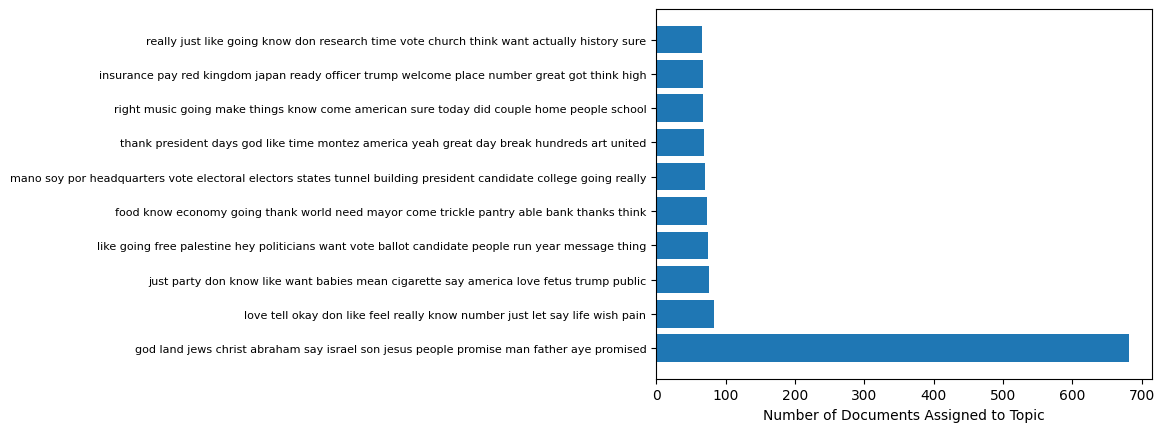

In [193]:
plt.barh(df_use['topic_words'][:10], df_use['Num Documents'][:10])
plt.xlabel('Number of Videos Assigned to Topic')
plt.tick_params(axis='y', which='major', labelsize=8)
plt.savefig('docs_assigned_to_topic_top10.png', bbox_inches='tight')